In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!pip install -q prophet statsmodels pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cuda


In [5]:
url = "https://raw.githubusercontent.com/datasets/gdp/master/data/gdp.csv"
df_gdp = pd.read_csv(url)

url_wheat = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-01/key_crop_yields.csv"
df_crops = pd.read_csv(url_wheat)

df = df_crops[df_crops['Entity'] == 'United States'].copy()
df = df[['Year', 'Wheat (tonnes per hectare)']].dropna()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'], format='%Y')
df = df.sort_values('ds').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
df.head()

Dataset shape: (58, 2)
Date range: 1961-01-01 00:00:00 to 2018-01-01 00:00:00


,ds,y
0,1961-01-01,1.6070
1,1962-01-01,1.6809
2,1963-01-01,1.6949
3,1964-01-01,1.7344
4,1965-01-01,1.7853


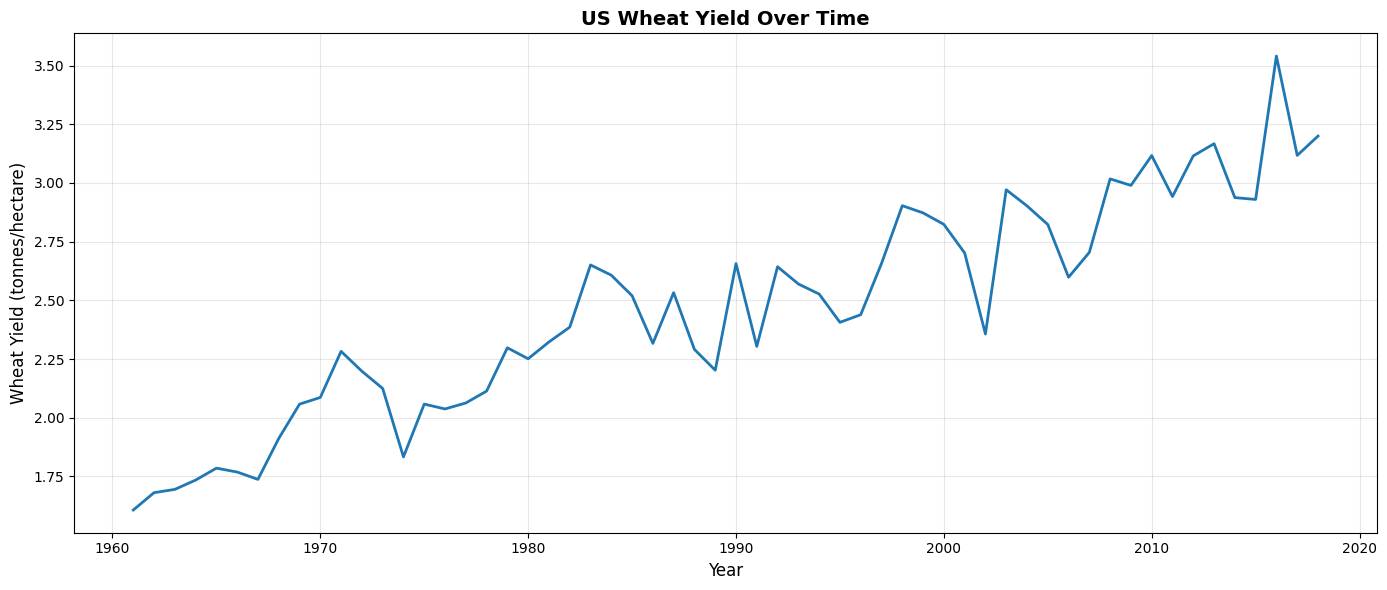

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], linewidth=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Wheat Yield (tonnes/hectare)', fontsize=12)
plt.title('US Wheat Yield Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
TRAIN_SIZE = 0.8
LOOKBACK = 5
FORECAST_HORIZON = 1
BATCH_SIZE = 16
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

train_size = int(len(df) * TRAIN_SIZE)
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 46
Test size: 12


## Baseline: ARIMA

In [8]:
def train_arima(train_data: pd.Series, order: Tuple[int, int, int] = (2, 1, 2)) -> ARIMA:
    model = ARIMA(train_data, order=order)
    fitted = model.fit()
    return fitted

def forecast_arima(model: ARIMA, steps: int) -> np.ndarray:
    forecast = model.forecast(steps=steps)
    return forecast.values

arima_model = train_arima(train_df['y'])
arima_forecast = forecast_arima(arima_model, len(test_df))

print("ARIMA model trained")

ARIMA model trained


## Prophet Model

In [9]:
def train_prophet(train_data: pd.DataFrame) -> Prophet:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    model.fit(train_data)
    return model

def forecast_prophet(model: Prophet, periods: int) -> pd.DataFrame:
    future = model.make_future_dataframe(periods=periods, freq='YS')
    forecast = model.predict(future)
    return forecast

prophet_model = train_prophet(train_df)
prophet_forecast = forecast_prophet(prophet_model, len(test_df))
prophet_predictions = prophet_forecast['yhat'].values[-len(test_df):]

print("Prophet model trained")

Prophet model trained


## LSTM Model

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data: np.ndarray, lookback: int, forecast_horizon: int):
        self.data = data
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon

    def __len__(self) -> int:
        return len(self.data) - self.lookback - self.forecast_horizon + 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[idx:idx + self.lookback]
        y = self.data[idx + self.lookback:idx + self.lookback + self.forecast_horizon]
        return torch.FloatTensor(x), torch.FloatTensor(y)

class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int, dropout: float = 0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [11]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['y']]).flatten()
test_scaled = scaler.transform(test_df[['y']]).flatten()

train_dataset = TimeSeriesDataset(train_scaled, LOOKBACK, FORECAST_HORIZON)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = LSTMModel(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    output_size=FORECAST_HORIZON,
    dropout=0.2
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

print(f"Model: {sum(p.numel() for p in model.parameters())} parameters")

Model: 50497 parameters


In [12]:
def train_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer) -> float:
    model.train()
    total_loss = 0.0

    for x, y in dataloader:
        x = x.unsqueeze(-1).to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

history = []
best_loss = float('inf')
patience_counter = 0
patience = 20

print("Training LSTM...")
for epoch in range(NUM_EPOCHS):
    loss = train_epoch(model, train_loader, criterion, optimizer)
    history.append(loss)
    scheduler.step(loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {loss:.6f}")

    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(torch.load('best_lstm_model.pth'))
print("LSTM training complete")

Training LSTM...
Epoch [20/200] Loss: 0.039831
Epoch [40/200] Loss: 0.020573
Epoch [60/200] Loss: 0.019567
Epoch [80/200] Loss: 0.021529
Early stopping at epoch 93
LSTM training complete


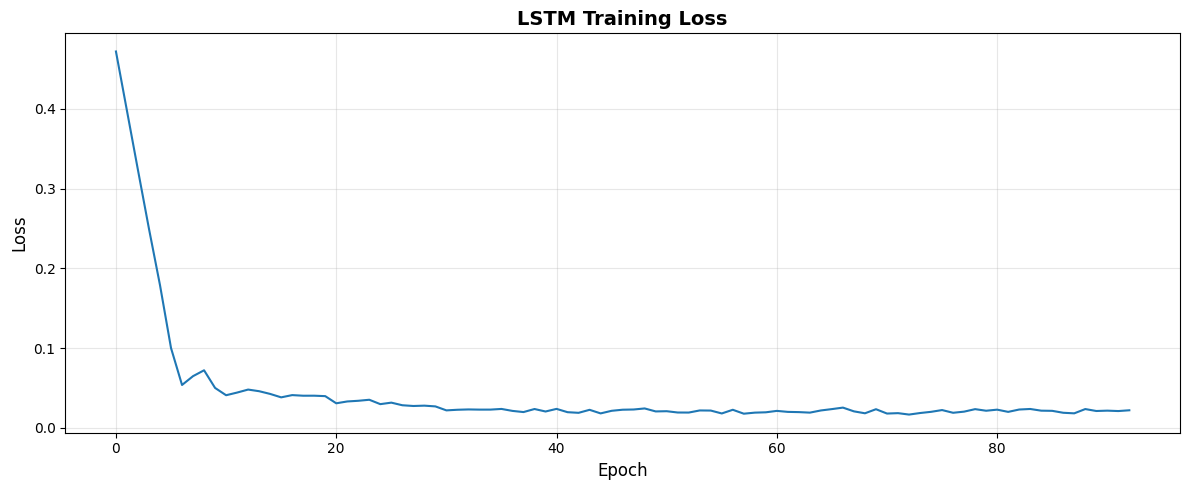

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(history)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

## Prophet + LSTM Hybrid

In [14]:
def predict_lstm(model: nn.Module, data: np.ndarray, lookback: int, steps: int) -> np.ndarray:
    model.eval()
    predictions = []
    current_sequence = data[-lookback:].copy()

    with torch.no_grad():
        for _ in range(steps):
            x = torch.FloatTensor(current_sequence).unsqueeze(0).unsqueeze(-1).to(DEVICE)
            pred = model(x).cpu().numpy()[0]
            predictions.append(pred[0])
            current_sequence = np.append(current_sequence[1:], pred[0])

    return np.array(predictions)

lstm_predictions_scaled = predict_lstm(model, train_scaled, LOOKBACK, len(test_df))
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled.reshape(-1, 1)).flatten()

hybrid_predictions = 0.6 * prophet_predictions + 0.4 * lstm_predictions

print("Hybrid model predictions generated")

Hybrid model predictions generated


## Metrics

In [15]:
def calculate_mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return mean_absolute_percentage_error(y_true, y_pred) * 100

def calculate_smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

def calculate_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

y_true = test_df['y'].values

results = {
    'ARIMA': {
        'predictions': arima_forecast,
        'MAPE': calculate_mape(y_true, arima_forecast),
        'SMAPE': calculate_smape(y_true, arima_forecast),
        'RMSE': calculate_rmse(y_true, arima_forecast)
    },
    'Prophet': {
        'predictions': prophet_predictions,
        'MAPE': calculate_mape(y_true, prophet_predictions),
        'SMAPE': calculate_smape(y_true, prophet_predictions),
        'RMSE': calculate_rmse(y_true, prophet_predictions)
    },
    'LSTM': {
        'predictions': lstm_predictions,
        'MAPE': calculate_mape(y_true, lstm_predictions),
        'SMAPE': calculate_smape(y_true, lstm_predictions),
        'RMSE': calculate_rmse(y_true, lstm_predictions)
    },
    'Prophet+LSTM': {
        'predictions': hybrid_predictions,
        'MAPE': calculate_mape(y_true, hybrid_predictions),
        'SMAPE': calculate_smape(y_true, hybrid_predictions),
        'RMSE': calculate_rmse(y_true, hybrid_predictions)
    }
}

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Model':<15} {'MAPE (%)':<12} {'SMAPE (%)':<12} {'RMSE':<10}")
print("-"*70)
for model_name, metrics in results.items():
    print(f"{model_name:<15} {metrics['MAPE']:<12.2f} {metrics['SMAPE']:<12.2f} {metrics['RMSE']:<10.4f}")


MODEL COMPARISON
Model           MAPE (%)     SMAPE (%)    RMSE      
----------------------------------------------------------------------
ARIMA           11.57        12.45        0.4119    
Prophet         3.98         4.01         0.1573    
LSTM            6.52         6.84         0.2580    
Prophet+LSTM    4.57         4.70         0.1856    


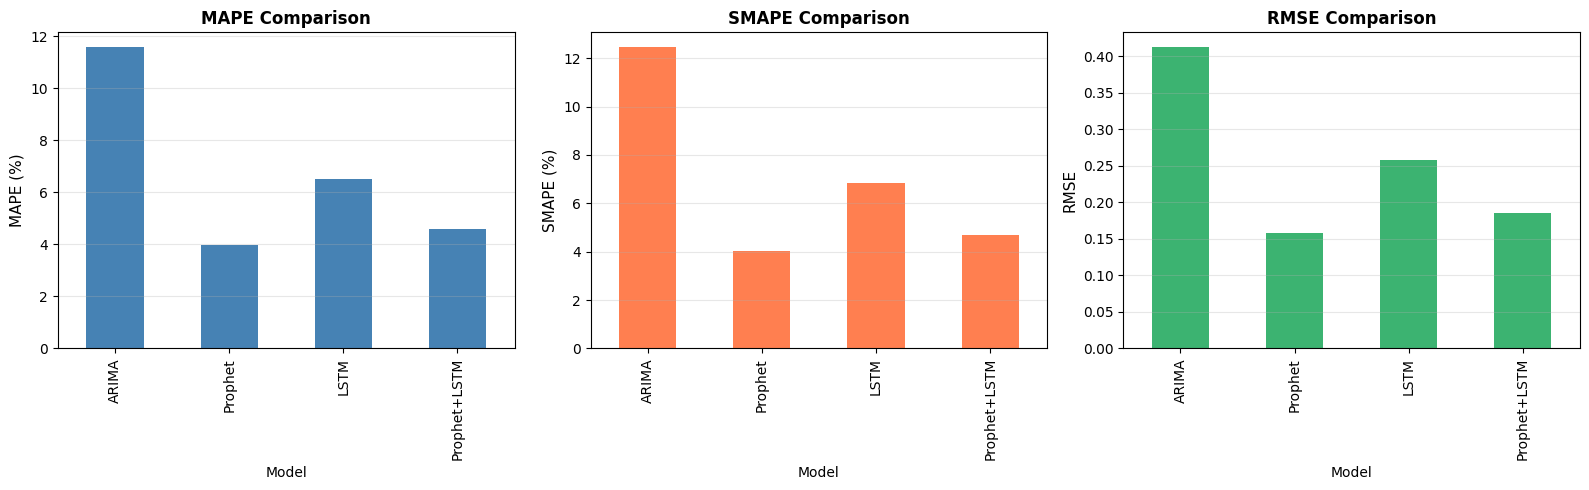

In [16]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAPE': [results[m]['MAPE'] for m in results.keys()],
    'SMAPE': [results[m]['SMAPE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()]
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_df.plot(x='Model', y='MAPE', kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('MAPE Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MAPE (%)', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

metrics_df.plot(x='Model', y='SMAPE', kind='bar', ax=axes[1], legend=False, color='coral')
axes[1].set_title('SMAPE Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('SMAPE (%)', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

metrics_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[2], legend=False, color='mediumseagreen')
axes[2].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('RMSE', fontsize=11)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

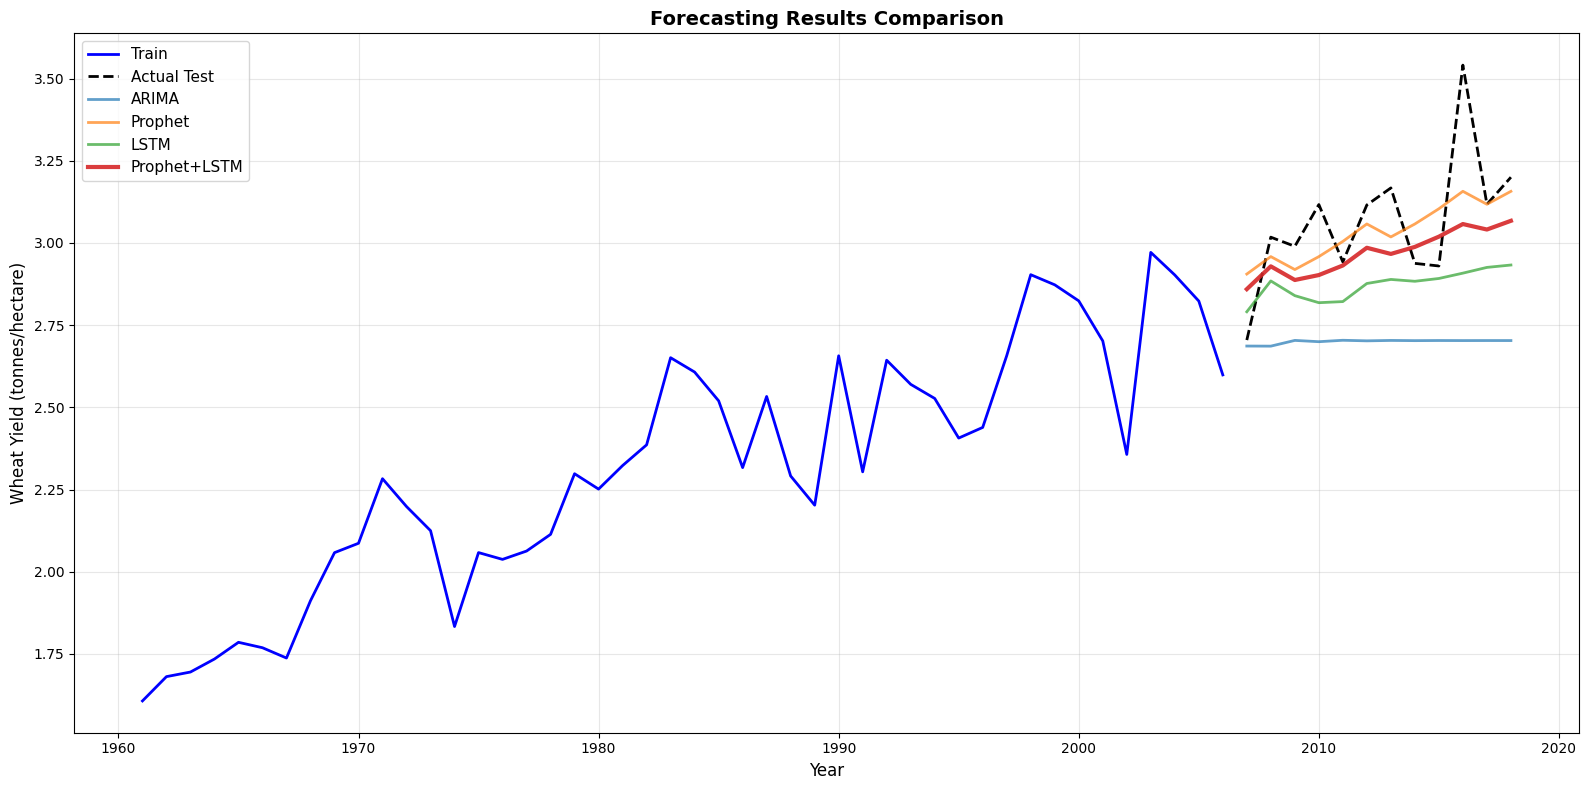

In [17]:
plt.figure(figsize=(16, 8))

plt.plot(train_df['ds'], train_df['y'], label='Train', linewidth=2, color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Actual Test', linewidth=2, color='black', linestyle='--')

plt.plot(test_df['ds'], results['ARIMA']['predictions'], label='ARIMA', linewidth=2, alpha=0.7)
plt.plot(test_df['ds'], results['Prophet']['predictions'], label='Prophet', linewidth=2, alpha=0.7)
plt.plot(test_df['ds'], results['LSTM']['predictions'], label='LSTM', linewidth=2, alpha=0.7)
plt.plot(test_df['ds'], results['Prophet+LSTM']['predictions'], label='Prophet+LSTM', linewidth=3, alpha=0.9)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Wheat Yield (tonnes/hectare)', fontsize=12)
plt.title('Forecasting Results Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('forecast_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

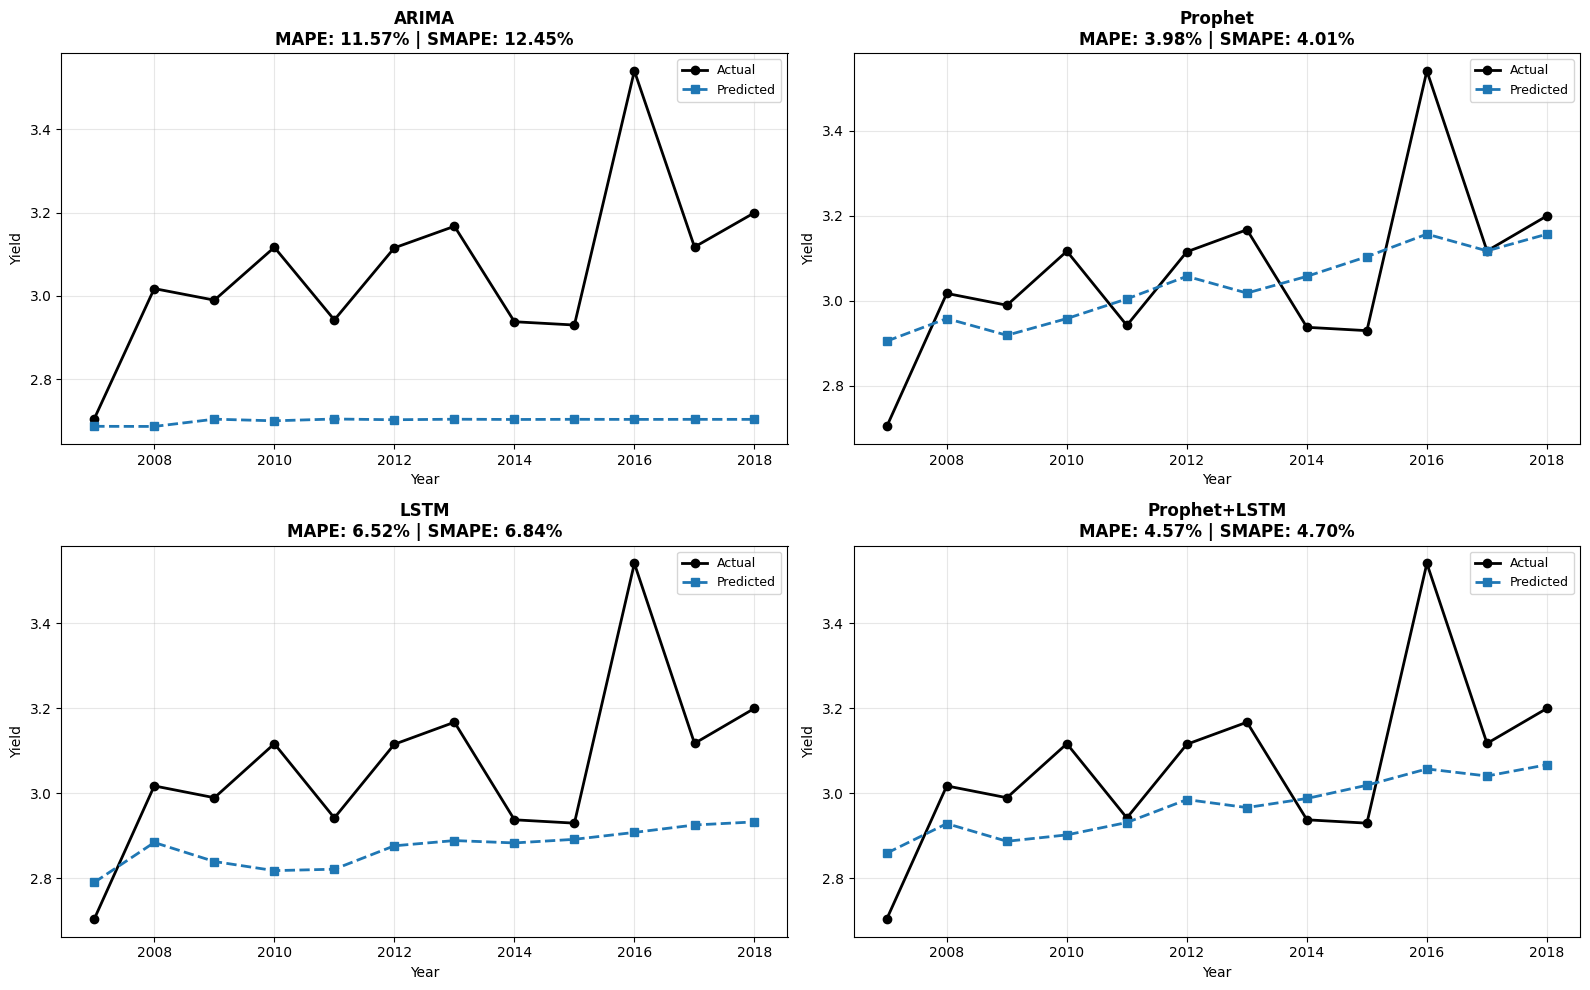

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models_list = ['ARIMA', 'Prophet', 'LSTM', 'Prophet+LSTM']
for idx, model_name in enumerate(models_list):
    ax = axes[idx // 2, idx % 2]

    ax.plot(test_df['ds'], test_df['y'], label='Actual', linewidth=2, color='black', marker='o')
    ax.plot(test_df['ds'], results[model_name]['predictions'], label='Predicted', linewidth=2, linestyle='--', marker='s')

    ax.set_title(f"{model_name}\nMAPE: {results[model_name]['MAPE']:.2f}% | SMAPE: {results[model_name]['SMAPE']:.2f}%",
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel('Yield', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('individual_forecasts.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
best_model = min(results.items(), key=lambda x: x[1]['MAPE'])

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Best Model: {best_model[0]}")
print(f"MAPE: {best_model[1]['MAPE']:.2f}%")
print(f"SMAPE: {best_model[1]['SMAPE']:.2f}%")
print(f"RMSE: {best_model[1]['RMSE']:.4f}")
print("\nImprovement over ARIMA baseline:")
print(f"  MAPE: {results['ARIMA']['MAPE'] - best_model[1]['MAPE']:.2f}% better")
print(f"  SMAPE: {results['ARIMA']['SMAPE'] - best_model[1]['SMAPE']:.2f}% better")
print("\nFiles saved:")
print("  - best_lstm_model.pth")
print("  - lstm_training_loss.png")
print("  - metrics_comparison.png")
print("  - forecast_comparison.png")
print("  - individual_forecasts.png")


SUMMARY
Best Model: Prophet
MAPE: 3.98%
SMAPE: 4.01%
RMSE: 0.1573

Improvement over ARIMA baseline:
  MAPE: 7.59% better
  SMAPE: 8.44% better

Files saved:
  - best_lstm_model.pth
  - lstm_training_loss.png
  - metrics_comparison.png
  - forecast_comparison.png
  - individual_forecasts.png
